In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

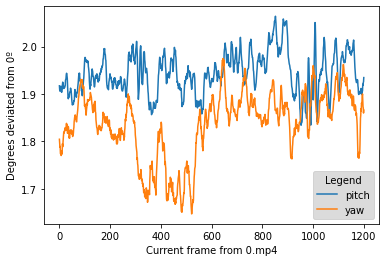

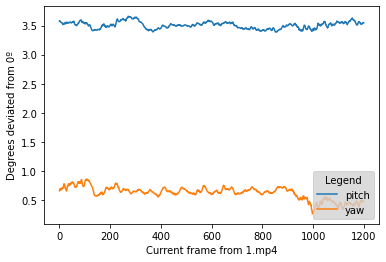

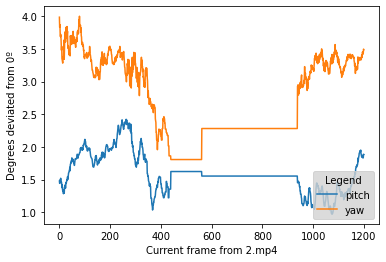

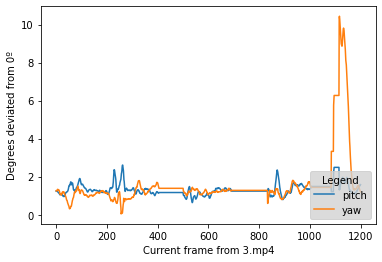

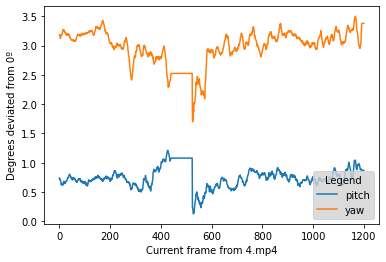

In [2]:
# Convert the labeled pitch and yaw 2d array of radians into degrees

# Create the plots for all labeled videos with pitch/yaw 

for num in range(5):
  pitch_yaw_arr = np.empty((0, 2))

  with open('calib_challenge/labeled/txt/{}.txt'.format(num), 'r') as file:
    for line in file:
      line = line.strip()
      str_list = line.split()
      if str_list[0] == 'nan':
        str_list[0] = pitch_yaw_arr[len(pitch_yaw_arr) - 1][0]
        str_list[1] = pitch_yaw_arr[len(pitch_yaw_arr) - 1][1]
      else:
        flt_list = [float(x) * 180/math.pi for x in str_list]
      pitch_yaw_arr = np.vstack((pitch_yaw_arr, flt_list))

  pitch = pitch_yaw_arr[:, 0]
  yaw = pitch_yaw_arr[:, 1]

  fig, ax = plt.subplots()

  ax.plot(np.arange(0, 1200), pitch, label = 'pitch')
  ax.plot(np.arange(0, 1200), yaw, label = 'yaw')
  ax.set_xlabel(xlabel = "Current frame from {}.mp4".format(num))
  ax.set_ylabel(ylabel = "Degrees deviated from 0º")
  ax.legend(loc='lower right', title='Legend', facecolor='lightgray')

# Pitch in blue, yaw in orange. We expect that yaw to have changed (14-22 / 280-44 for 0.txt) because there's a subtle left turn.

# 60 seconds / 20 fps
# 48 seconds / 25 fps

# 48 seconds => 300 / 550 => 12 / 22


<ipython-input-3-8e1071d48144>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


KeyboardInterrupt: 

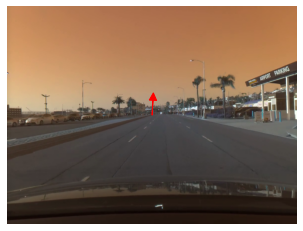

In [3]:
# Testing movement of yaw arrow direction from any of the MP4s in question

# Read the video
path = 'calib_challenge/labeled/mp4/4.mp4'
video_capture = cv2.VideoCapture(path)

# Get the width and height of the video
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('calib_challenge/labeled/0v.mp4', fourcc, fps, (1164, 874))

# Vector parameters
origin = (width // 2, height // 2)  # Origin point of the vector
magnitude = 60  # Magnitude of the vector
angle = 270  # Angle of the vector (in degrees)

# Pitch/yaw angle from current frame_ct
frame_ct = 0

# Read the video frame by frame
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if ret:
        # Draw the vector on the frame
        ax = plt.subplot(111)
        ax.clear()
        ax.imshow(frame)
        # Turns arrow by adding to the angle it is to be displaced by
        ax.arrow(origin[0], origin[1], magnitude * np.cos(np.deg2rad(angle + yaw[frame_ct])), magnitude * np.sin(np.deg2rad(angle + yaw[frame_ct])), head_width=30, head_length=30, fc='r', ec='r')
        plt.axis('off')
        plt.savefig('frame.png', bbox_inches='tight', pad_inches=0)
        frame = cv2.imread('frame.png')
        # Write the modified frame to the output video
        video_writer.write(frame)
    else:
        break
    # Add one for the next frame in the 1D pitch/yaw array
    frame_ct += 1

# Release the video capture and writer objects
video_capture.release()
video_writer.release()

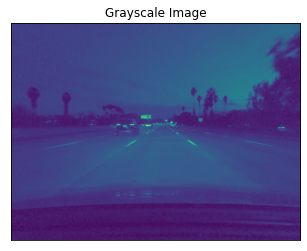

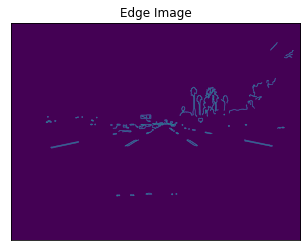

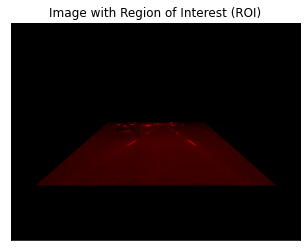

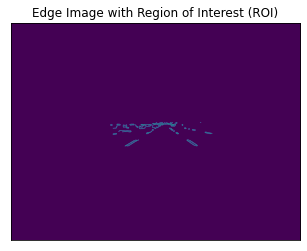

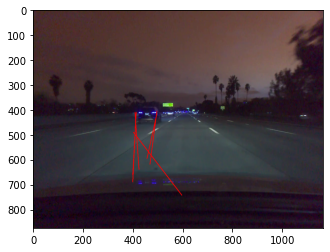

In [132]:
# Problem with this is that we are working with pre-configured values for a 289x217 image frame
# We need the original 1164x874 image so that Canny edge detector performs task better

# Canny Edge Detector and Hough Transform

# Obtain a 1164x874 image frame of a given video with VideoCapture object
path = 'calib_challenge/labeled/mp4/0.mp4'
video_capture = cv2.VideoCapture(path)

# Should iterate through video here to store all frames somewhere... for now a single frame

ret, image = video_capture.read()

video_capture.release()

# Read the image and convert to grayscale
# image = cv2.imread('testframe.png') [TEMPORARY FOR 1164x874 FRAME]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.title('Grayscale Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Apply the Gaussian blur to reduce noise for Canny edge
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 33, 100) # threshold for daylight (50/100), night (50/150)?
plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Define a region of interest (ROI) for the lanes
imshape = edges.shape # obtains height, width, and (?) third parameter
triangle = np.array([ # define a hard-coded region of interest where lane lines are
                    [(25, imshape[0] - 50), # left vertex
                    (int(imshape[1] / 2), int(imshape[0] / 2) - 200), # middle vertex
                    (imshape[1] - 25, imshape[0] - 50)] # right vertex
                    ]) 
square = np.array([
                  [(100, int(3 * imshape[0] / 4)), # bottom left vertex
                  (int(imshape[1] / 3), int(imshape[0] / 2) - 35), # upper left vertex
                  (int(2 * imshape[1] / 3), int(imshape[0] / 2) - 35), # upper right vertex
                  (imshape[1] - 100, int(3 * imshape[0] / 4))] # bottom right vertex
                  ])

# Region of interest but for the image itself
image_mask = np.zeros_like(image)
cv2.fillPoly(image_mask, square, 255)
masked_image = cv2.bitwise_and(image, image_mask)
plt.imshow(masked_image)
plt.title('Image with Region of Interest (ROI)'), plt.xticks([]), plt.yticks([])
plt.show()

# Region of interest but for the edges
edge_mask = np.zeros_like(edges) # define a black plane, this is where we define our hard-coded region
cv2.fillPoly(edge_mask, square, 255) # fill this region with an intensity of 255 inside triangle (vertices)
masked_edges = cv2.bitwise_and(edges, edge_mask) # bitwise_and to define edges ONLY inside the marked region, everything outside is 0
plt.imshow(masked_edges)
plt.title('Edge Image with Region of Interest (ROI)'), plt.xticks([]), plt.yticks([])
plt.show()

# Testing Hough transform to detect lines in grid
rho = 2 # distance resolution in pixels of Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100 # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100 # minimum number of pixels making up a line
max_line_gap = 100 # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    for x1, x2, y1, y2 in line:
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(image)
plt.show()


In [9]:
# Ideas:

# Knowing pitch and yaw angle is relative to camera frame, we need to check whether
# it is relative to two perpendicular lines running through the middle of the frame.
# -> Check if the vanishing point is the relative point to the middle of the frame, then we can just use lane detection/parallel lines to estimate direction of travel.
# -> Vanishing point ought to be defining the pitch and yaw angle depending on its location.

# Define the amount of pitch/uaw the PHYSICAL camera moves from the original middle of frame to the vanishing point location

# ---------------

# CV Approach:
# "Parallel lines in frame coordinates should yield vectors parallel to the Z axis after unprojection into camera space and deviation in their angles would solve for pitch and yaw."
# We can obtain parallel lines, unproject them into camera frame, then find for the deviations in their angles (compensating for DISTORTION)
# Once the lane lines have been unprojected into the camera frame (from Z axis to X, Y values), we then check for their deviations.

# ---------------

# Machine Learning Approach:
# This might be really extreme stretch, but maybe?
# Classification using neural networks to be able to predict the pitch and yaw given the vanishing point in frame, trained on the labeled dataset vanishing point values.
# Can be precisely centered around the fact that central point in frame is (Pitch/Yaw) => (0,0)?
# For this, we need a method that can estimate vanishing points correctly. 

# We may also need to compensate for camera orientation corrections... not absolute, may need to estimate this beforehand to adjust the output pitch/yaw values?
# For this, we not only have to take into consideration the unlabeled videos, but labeled as well to recalculate vanishing points maybe?